# Doc2Vec for speech2011 similiarity_without_GPE_new

by pg9349

This code is for generating speech embeddings and clustering using various techniques and storing results of DBscan clutering into a json file to be used for topic modelling

In [1]:
from gensim.models import Doc2Vec
import smart_open
from gensim.models.doc2vec import TaggedDocument

In [2]:
import multiprocessing
from tqdm import tqdm
cores = multiprocessing.cpu_count()

In [3]:
import numpy as np

In [4]:
import pandas as pd
df=pd.read_json("un_speeches_tokenised.json",orient='records',compression='infer')

In [5]:
df.columns

Index(['doc', 'Year', 'Session', 'ISO Code', 'Country',
       'Name of Person Speaking', 'Post', 'Language', 'Notes', 'sent_split',
       'word_split', 'count_speech_words', 'count_speech_sent'],
      dtype='object')

### Getting the respective years speech

In [6]:
speech19=df[df['Year']==2011.0]
# speech18=df[df['Year']==2018.0]
# speech17=df[df['Year']==2017.0]

In [7]:
usa19=speech19[speech19['ISO Code']=='USA']['doc'].values
alb19=speech19[speech19['ISO Code']=='ALB']['doc'].values
cuba19=speech19[speech19['ISO Code']=='CUB']['doc'].values
ven19=speech19[speech19['ISO Code']=='VEN']['doc'].values

In [3]:
import spacy
from spacy import displacy

NER = spacy.load("en_core_web_sm")

### Analysing speeches for Cross reference of other nations in speeches

In [9]:
text1= NER(str(usa19))
displacy.render(text1,style="ent",jupyter=True)

In [10]:
text1= NER(str(alb19))
displacy.render(text1,style="ent",jupyter=True)

In [11]:
text1= NER(str(cuba19))
displacy.render(text1,style="ent",jupyter=True)

In [12]:
text1= NER(str(ven19))
displacy.render(text1,style="ent",jupyter=True)

In [13]:
countries=set()
for i in speech19['doc']:
    text= NER(str(i))
    for word in text.ents:
        country,gpe=word.text,word.label_
        if gpe=="GPE":
            countries.add(country)
       
    

In [14]:
countries
def removegpe(x):
    l=[]
    for i in x:
        if i not in countries:
            l.append(i)
    return l
            

In [15]:
speech19['word_split_withoutgpe']=speech19['word_split'].apply(removegpe)

<ipython-input-15-ac26de496abb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  speech19['word_split_withoutgpe']=speech19['word_split'].apply(removegpe)


In [16]:
for i in speech19['word_split'][:10]:
    print(len(i))

2769
1919
3404
2332
1581
3552
2043
3570
3030
1695


In [17]:
for i in speech19['word_split_withoutgpe'][:10]:
    print(len(i))

2476
1706
3106
2152
1414
3267
1845
3296
2737
1511


In [18]:
doc19=speech19['word_split_withoutgpe']

### Creating Tagged Documents for Doc2Vec model

In [19]:
# train_tagged = TaggedDocument(words=doc19, tags=[i for i in range(len(doc19))])
# # train_tagged = train.apply(
# #     lambda r: TaggedDocument(words=tokenize_text(r['description']), tags=[r.issue]), axis=1)
i=0
train_tagged = [TaggedDocument(doc, [i]) for i, doc in enumerate(doc19)]

In [20]:
train_tagged

[TaggedDocument(words=['I', 'am', 'honoured', 'to', 'be', 'here', 'to', 'read', 'statement', 'of', 'my', 'President', ',', 'His', 'Excellency', 'Hâmid', 'Karzai', ',', 'who', 'had', 'to', 'return', 'from', 'New', 'York', 'to', 'on', 'an', 'urgent', 'basis', ',', 'following', 'tragic', 'assassination', ',', 'through', 'a', 'terrorist', 'plot', ',', 'of', '’', 's', 'former', 'President', 'and', 'Chairman', 'of', 'High', 'Peace', ',', 'Mr.', 'Burhanuddin', 'Rabbani', '.', 'The', 'President', '’', 's', 'message', 'begins', ':', '“', 'It', 'is', 'a', 'great', 'honour', 'to', 'address', 'General', 'Assembly', 'at', 'this', 'year', '’', 's', 'session', ',', 'although', 'I', 'regret', 'that', 'I', 'am', 'unable', 'to', 'do', 'so', 'in', 'person', '.', 'I', 'was', 'here', 'in', 'New', 'York', 'day', 'before', 'yesterday', 'and', 'had', 'looked', 'forward', 'to', 'attending', 'this', 'important', 'session', 'of', 'Assembly', '.', 'I', 'had', 'to', 'return', 'to', 'after', 'tragic', 'news', 'of',

In [21]:

# model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow = Doc2Vec(seed=42,dm=0, vector_size=50, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow

In [22]:

# model_dbow.build_vocab(train_tagged)
model_dbow.build_vocab([x for x in tqdm(train_tagged)])

100%|████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 190829.96it/s]


In [23]:

from sklearn import utils
for epoch in range(30):
    model_dbow.train([x for x in tqdm(train_tagged)], total_examples=len(train_tagged), epochs=1)
#     model_dbow.alpha -= 0.002
#     model_dbow.min_alpha = model_dbow.alpha

100%|████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<?, ?it/s]


In [24]:
model_dbow.save("doc2vec_new_without_gpe_2011.model")

### Load the saved mode

In [ ]:

model = Doc2Vec.load("doc2vec_new_without_gpe_2011.model")

In [26]:

def vec_for_learning(model, tagged_docs):
    sents = tagged_docs
    model.random.seed(42)
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, epochs=20)) for doc in sents])
    return targets, regressors

In [27]:
_, X_train = vec_for_learning(model, train_tagged)

In [28]:
X_train=np.array(X_train)

In [29]:
X_train[0]

array([ 0.5319655 ,  0.76553845,  0.36916512, -0.75057125, -0.68186283,
        0.4885259 , -0.9389819 ,  0.24615781, -0.8385384 , -2.0175176 ,
       -0.7326095 ,  1.8244177 ,  0.18355888, -0.84492517, -0.21856156,
        0.32077917,  0.8726108 ,  0.2725937 , -1.3379196 ,  0.96515316,
        0.23148063,  0.26749277, -0.95264125, -0.9024998 , -0.35643628,
       -0.25463524,  1.251021  ,  0.12466715, -0.8615663 ,  0.47060105,
       -0.50763726, -0.6575593 , -0.43097273, -0.04278924,  0.1259961 ,
       -0.6420693 , -0.420175  , -0.00506457,  0.34974635, -0.39289433,
       -0.3367349 , -0.37654334, -0.20958199, -0.58141756, -0.17852835,
        0.97434354, -1.3934133 ,  0.6121289 ,  0.17868172, -1.0796767 ],
      dtype=float32)

In [30]:
X_train[0]

array([ 0.5319655 ,  0.76553845,  0.36916512, -0.75057125, -0.68186283,
        0.4885259 , -0.9389819 ,  0.24615781, -0.8385384 , -2.0175176 ,
       -0.7326095 ,  1.8244177 ,  0.18355888, -0.84492517, -0.21856156,
        0.32077917,  0.8726108 ,  0.2725937 , -1.3379196 ,  0.96515316,
        0.23148063,  0.26749277, -0.95264125, -0.9024998 , -0.35643628,
       -0.25463524,  1.251021  ,  0.12466715, -0.8615663 ,  0.47060105,
       -0.50763726, -0.6575593 , -0.43097273, -0.04278924,  0.1259961 ,
       -0.6420693 , -0.420175  , -0.00506457,  0.34974635, -0.39289433,
       -0.3367349 , -0.37654334, -0.20958199, -0.58141756, -0.17852835,
        0.97434354, -1.3934133 ,  0.6121289 ,  0.17868172, -1.0796767 ],
      dtype=float32)

### Dim reduction using TSNE

In [ ]:
import numpy as np
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2, learning_rate='auto',
                  random_state=42, perplexity=3).fit_transform(X_train)
X_embedded.shape

In [32]:
viz=pd.DataFrame(X_embedded,columns=["dim1","dim2"])

In [33]:
speech19['ISO Code']

6539    AFG
6540    AGO
6541    ALB
6542    AND
6543    ARE
       ... 
6728    WSM
6729    YEM
6730    ZAF
6731    ZMB
6732    ZWE
Name: ISO Code, Length: 193, dtype: object

In [34]:
viz['country_code']=speech19['ISO Code'].values
viz['country']=speech19['Country'].values

In [35]:
viz.columns

Index(['dim1', 'dim2', 'country_code', 'country'], dtype='object')

In [36]:
viz

dim1       dim2 country_code       country
0   -11.006799   1.454446          AFG   Afghanistan
1   -24.030167  16.811480          AGO        Angola
2    34.088444  -4.367913          ALB       Albania
3     1.497321 -21.666798          AND       Andorra
4   -38.190144  15.585642          ARE           UAE
..         ...        ...          ...           ...
188   3.965129  32.973652          WSM         Samoa
189 -39.369507   6.152997          YEM         Yemen
190  14.670299   6.425254          ZAF  South Africa
191   5.868094  22.373243          ZMB        Zambia
192   4.852846   9.403378          ZWE      Zimbabwe

[193 rows x 4 columns]

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

def scatter_text(x, y, text_column, data, title, xlabel, ylabel):

    # Create the scatter plot
    p1 = sns.scatterplot(x, y, data=data, size = 8, legend=False)
    # Add text besides each point
    for line in range(0,data.shape[0]):
#         print(data[text_column][line])   
        p1.text(data[x][line]+0.01, data[y][line], 
                 data[text_column][line], horizontalalignment='left', 
                 size='medium', weight='semibold')
    # Set title and axis labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    return p1

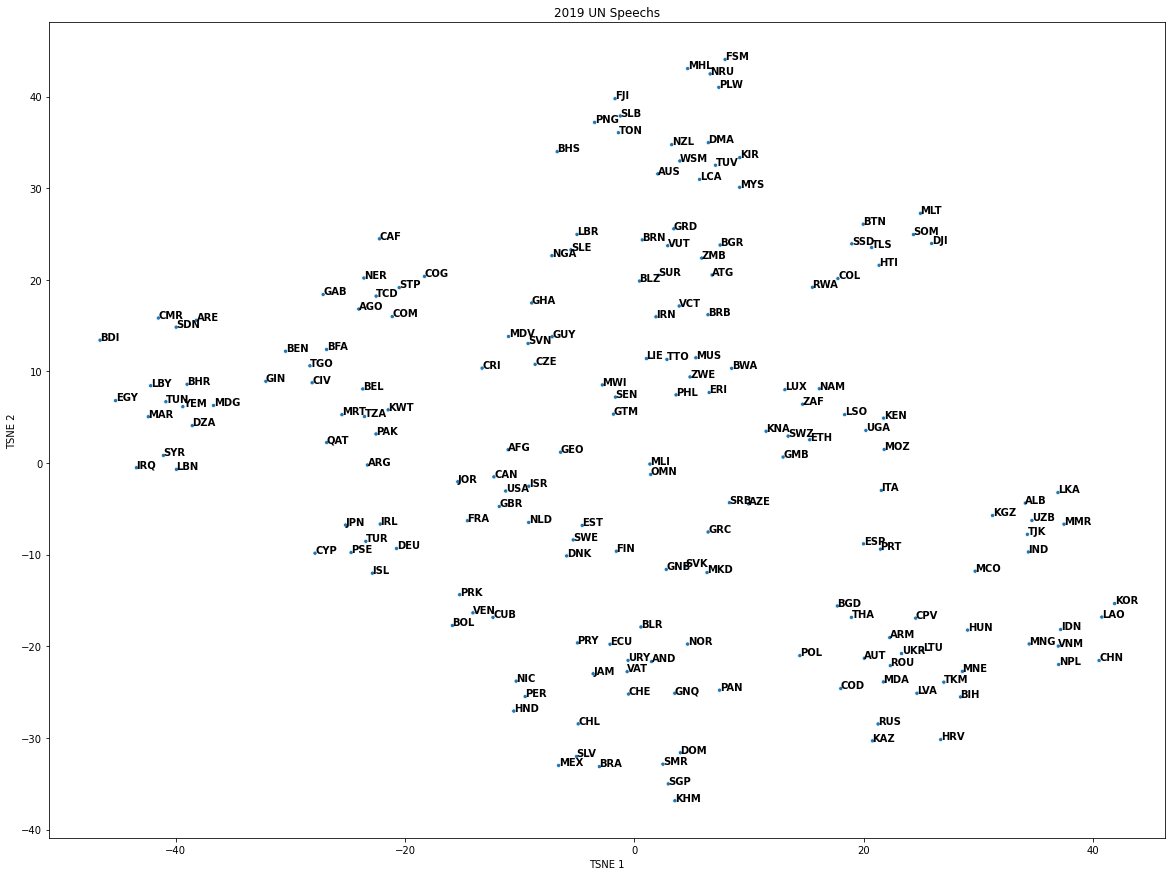

In [38]:
plt.figure(figsize=(20,15))
scatter_text('dim1', 'dim2', 'country_code',
             data = viz, 
             title = '2019 UN Speechs', 
             xlabel = 'TSNE 1',
             ylabel = 'TSNE 2')

In [39]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
speech19[['ISO Code','Country']].head(200)

ISO Code                         Country
6539      AFG                     Afghanistan
6540      AGO                          Angola
6541      ALB                         Albania
6542      AND                         Andorra
6543      ARE                             UAE
6544      ARG                       Argentina
6545      ARM                         Armenia
6546      ATG             Antigua and Barbuda
6547      AUS                       Australia
6548      AUT                         Austria
6549      AZE                      Azerbaijan
6550      BDI                         Burundi
6551      BEL                         Belgium
6552      BEN                           Benin
6553      BFA                    Burkina Faso
6554      BGD                      Bangladesh
6555      BGR                        Bulgaria
6556      BHR                         Bahrain
6557      BHS                         Bahamas
6558      BIH          Bosnia and Herzegovina
6559      BLR                         Belarus
6560      BLZ                          Belize
6561      BOL                         Bolivia
6562      BRA                          Brazil
6563      BRB                        Barbados
6564      BRN               Brunei Darussalam
6565      BTN                          Bhutan
6566      BWA                        Botswana
6567      CAF        Central African Republic
6568      CAN                          Canada
6569      CHE                     Switzerland
6570      CHL                           Chile
6571      CHN                           China
6572      CIV                   Cote d'Ivoire
6573      CMR                        Cameroon
6574      COD    Democratic Republic Of Congo
6575      COG               Republic of Congo
6576      COL                        Colombia
6577      COM                         Comoros
6578      CPV                      Cape Verde
6579      CRI                      Costa Rica
6580      CUB                            Cuba
6581      CYP                          Cyprus
6582      CZE                  Czech Republic
6583      DEU                         Germany
6584      DJI                        Djibouti
6585      DMA                        Dominica
6586      DNK                         Denmark
6587      DOM              Dominican Republic
6588      DZA                         Algeria
6589      ECU                         Ecuador
6590      EGY                           Egypt
6591      ERI                         Eritrea
6592      ESP                           Spain
6593      EST                         Estonia
6594      ETH                        Ethiopia
6596      FIN                         Finland
6597      FJI                            Fiji
6598      FRA                          France
6599      FSM                      Micronesia
6600      GAB                           Gabon
6601      GBR                  United Kingdom
6602      GEO                         Georgia
6603      GHA                           Ghana
6604      GIN                          Guinea
6605      GMB                          Gambia
6606      GNB                   Guinea-Bissau
6607      GNQ               Equatorial Guinea
6608      GRC                          Greece
6609      GRD                         Grenada
6610      GTM                       Guatemala
6611      GUY                          Guyana
6612      HND                        Honduras
6613      HRV                         Croatia
6614      HTI                           Haiti
6615      HUN                         Hungary
6616      IDN                       Indonesia
6617      IND                           India
6618      IRL                         Ireland
6619      IRN                            Iran
6620      IRQ                            Iraq
6621      ISL                         Iceland
6622      ISR                          Israel
6623      ITA                           Italy
6624      JAM                         Jamaica
6625      JOR                          Jordan
662

In [40]:
import plotly.express as px

In [41]:
fig = px.scatter(viz, x="dim1", y="dim2",color="country",
                  hover_data=['country_code','country'],title="2011 UNGA speeches_without_GPE",text="country_code",width=1700,height=1200)
fig.show()

In [47]:
fig.write_html("speechs_2011_Without_GPE_new.html")

### Hierarchy clustering

In [59]:
import scipy.cluster.hierarchy as hac 

In [60]:
z = hac.linkage(viz[['dim1','dim2']], method='complete') 
labels = hac.fcluster(z, 1, criterion="distance")
labels = hac.fcluster(z, 30, criterion="distance")

In [61]:
labels

array([ 9, 10,  5,  1,  8, 10,  4,  7,  7,  4,  3,  8, 10, 10, 10,  4,  7,
        8,  7,  4,  1,  7,  2,  1,  7,  7,  6,  3, 10,  2,  1,  1,  5, 10,
        8,  4, 10,  6, 10,  5,  9,  2,  2,  9,  2,  6,  7,  2,  1,  8,  1,
        8,  3,  5,  2,  3,  2,  7,  2,  7, 10,  2,  9,  9, 10,  3,  1,  1,
        3,  7,  9,  9,  1,  4,  6,  5,  5,  5,  2,  7,  8,  2,  2,  3,  1,
        2,  2,  4,  3,  5,  1,  7,  3,  5, 10,  5,  8,  7,  8,  7,  3,  5,
        3,  4,  3,  4,  8,  5,  4,  8,  9,  1,  7,  1,  3,  6,  5,  4,  5,
        3, 10,  3,  9,  7,  3, 10,  7,  1,  2,  1,  5,  7,  7,  3, 10,  1,
        1,  3,  7,  7,  4,  2,  5,  1,  2, 10,  4,  4,  6,  8,  9,  1,  7,
        7,  1,  1,  6,  3,  6, 10,  7,  1,  9,  2,  3,  8, 10, 10,  4,  5,
        4,  6,  7,  3,  8,  2,  7, 10,  3,  4,  1,  2,  5,  1,  7,  2,  5,
        7,  7,  8,  3,  7,  3], dtype=int32)

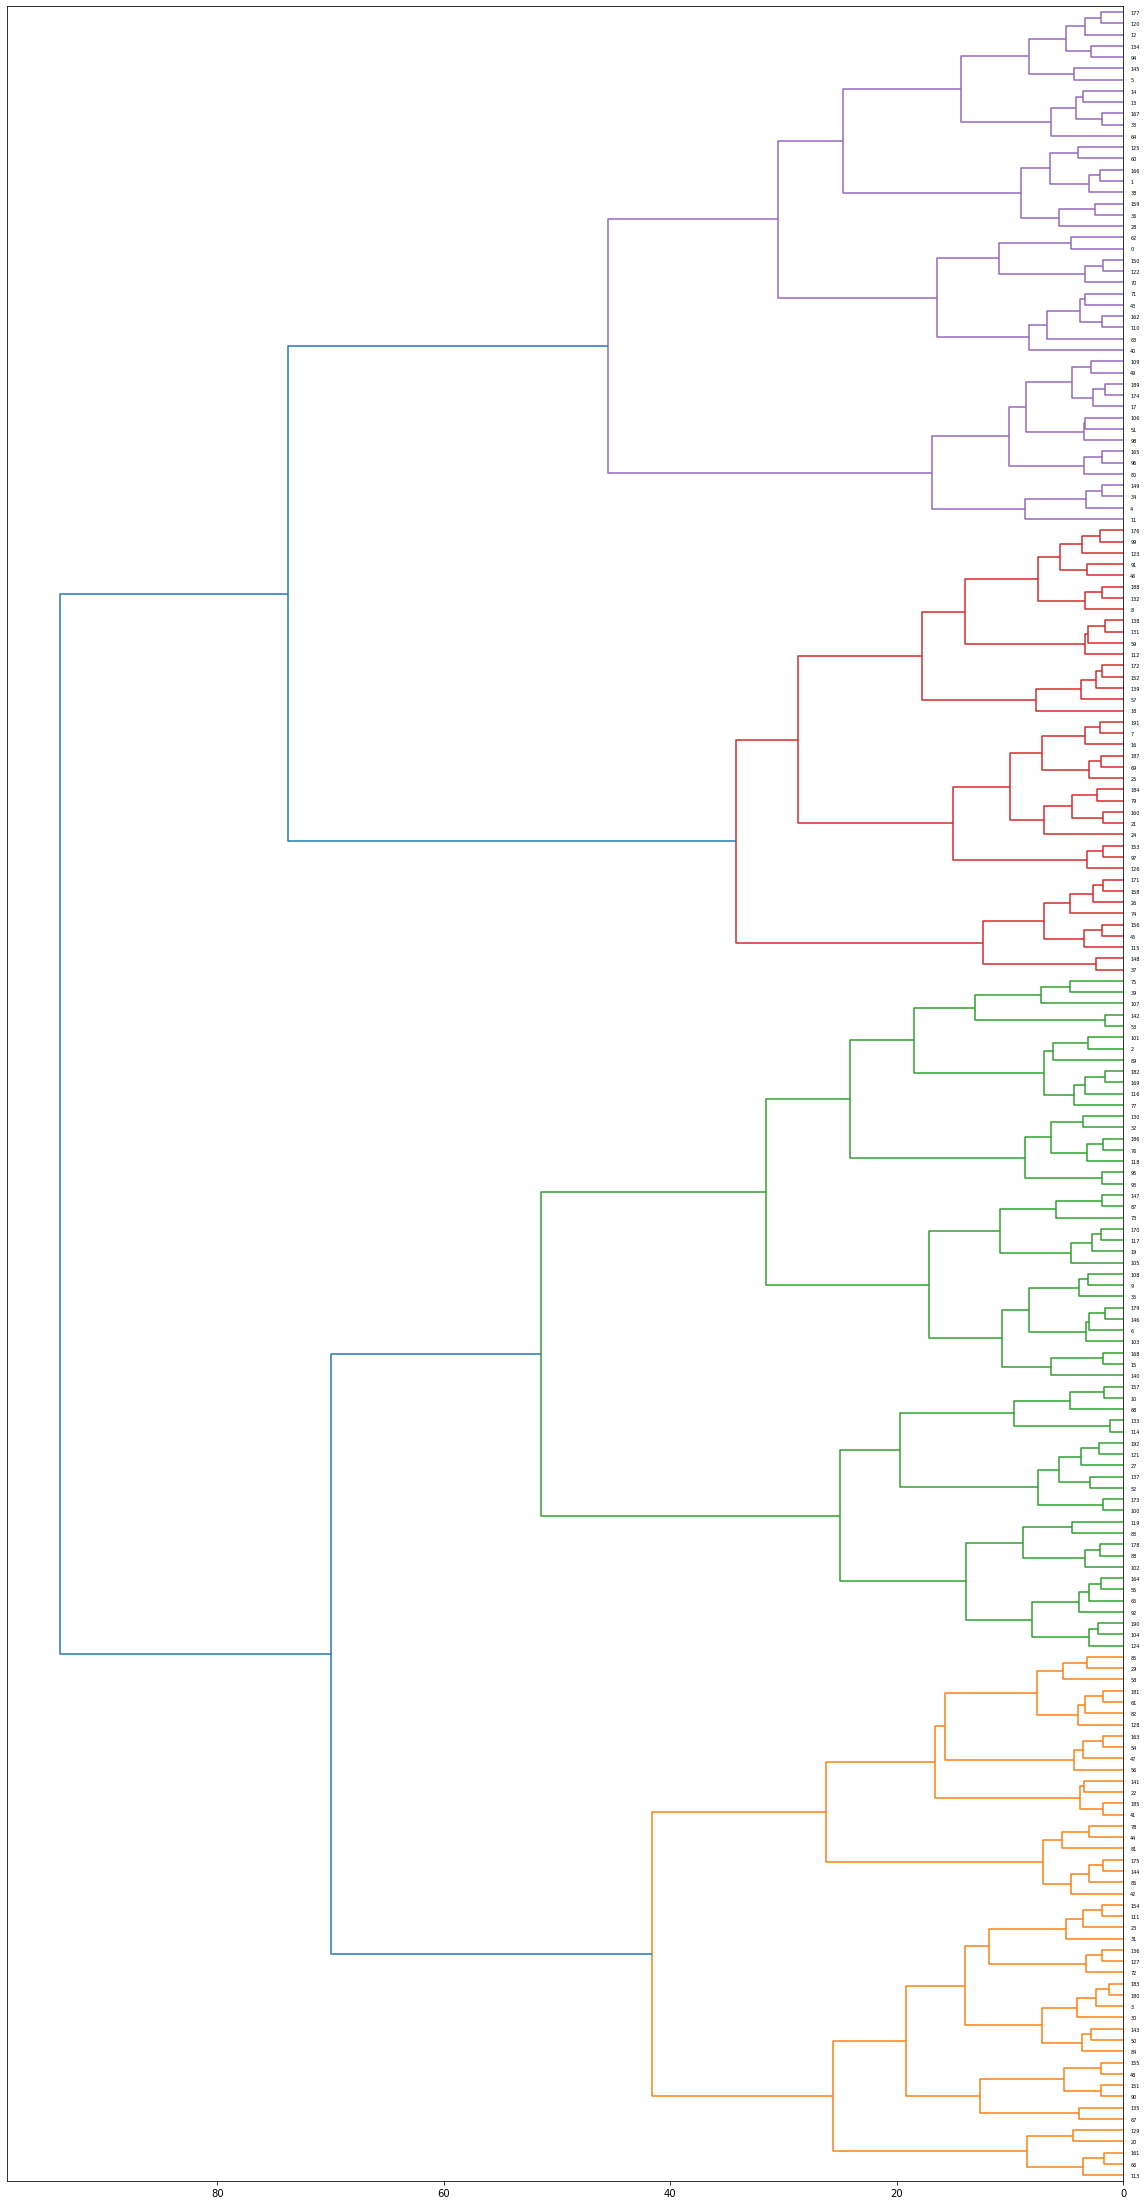

In [62]:
plt.figure(figsize=(20,40))
h=hac.dendrogram(z,orientation='left')
plt.show()

In [63]:
viz['labels']=["CLUSTER "+str(i) if i!=-1  else "Outlier or Noise" for i in labels ]

In [64]:
fig = px.scatter(viz, x="dim1", y="dim2",color="labels",
                  hover_data=['country_code','country'],title="2011 UNGA speeches without GPE hierarchy clustering",text="country_code",width=1700,height=1200)
fig.show()

In [65]:
fig.write_html("speechs_2011_Without_GPE_new_labels_dendogram.html")

### Clustering using KMeans

In [66]:
from sklearn.cluster import KMeans

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



Text(0, 0.5, 'Inertia')

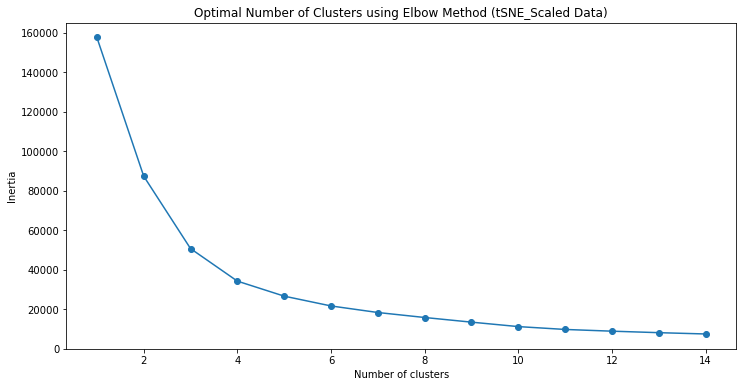

In [67]:
sse = []
k_list = range(1, 15)
for k in k_list:
    km = KMeans(n_clusters=k)
    km.fit(viz[['dim1','dim2']])
    sse.append([k, km.inertia_])
    
tsne_results_scale = pd.DataFrame({'Cluster': range(1,15), 'SSE': sse})
plt.figure(figsize=(12,6))
plt.plot(pd.DataFrame(sse)[0], pd.DataFrame(sse)[1], marker='o')
plt.title('Optimal Number of Clusters using Elbow Method (tSNE_Scaled Data)')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [68]:
viz

dim1       dim2 country_code                         country      labels
0   -11.006799   1.454446          AFG                     Afghanistan   CLUSTER 9
1   -24.030167  16.811480          AGO                          Angola  CLUSTER 10
2    34.088444  -4.367913          ALB                         Albania   CLUSTER 5
3     1.497321 -21.666798          AND                         Andorra   CLUSTER 1
4   -38.190144  15.585642          ARE                             UAE   CLUSTER 8
5   -23.274736  -0.209288          ARG                       Argentina  CLUSTER 10
6    22.270275 -19.051662          ARM                         Armenia   CLUSTER 4
7     6.779865  20.523945          ATG             Antigua and Barbuda   CLUSTER 7
8     2.043280  31.566105          AUS                       Australia   CLUSTER 7
9    20.047373 -21.298637          AUT                         Austria   CLUSTER 4
10    9.956106  -4.459935          AZE                      Azerbaijan   CLUSTER 3
11  -46.589031  13.412124          BDI                         Burundi   CLUSTER 8
12  -23.682188   8.090535          BEL                         Belgium  CLUSTER 10
13  -30.411642  12.207069          BEN                           Benin  CLUSTER 10
14  -26.834116  12.402146          BFA                    Burkina Faso  CLUSTER 10
15   17.700958 -15.596972          BGD                      Bangladesh   CLUSTER 4
16    7.477881  23.795460          BGR                        Bulgaria   CLUSTER 7
17  -38.999660   8.602991          BHR                         Bahrain   CLUSTER 8
18   -6.728516  33.985645          BHS                         Bahamas   CLUSTER 7
19   28.436251 -25.525713          BIH          Bosnia and Herzegovina   CLUSTER 4
20    0.576352 -17.889124          BLR                         Belarus   CLUSTER 1
21    0.447164  19.867004          BLZ                          Belize   CLUSTER 7
22  -15.868717 -17.734020          BOL                         Bolivia   CLUSTER 2
23   -3.052066 -33.131721          BRA                          Brazil   CLUSTER 1
24    6.418396  16.193117          BRB                        Barbados   CLUSTER 7
25    0.690931  24.358782          BRN               Brunei Darussalam   CLUSTER 7
26   19.959066  26.075922          BTN                          Bhutan   CLUSTER 6
27    8.482228  10.341574          BWA                        Botswana   CLUSTER 3
28  -22.229542  24.474360          CAF        Central African Republic  CLUSTER 10
29  -12.247355  -1.504595          CAN                          Canada   CLUSTER 2
30   -0.508567 -25.208820          CHE                     Switzerland   CLUSTER 1
31   -4.897873 -28.463408          CHL                           Chile   CLUSTER 1
32   40.520687 -21.552553          CHN                           China   CLUSTER 5
33  -28.096140   8.763072          CIV                   Cote d'Ivoire  CLUSTER 10
34  -41.502670  15.830708          CMR                        Cameroon   CLUSTER 8
35   18.000137 -24.607901          COD    Democratic Republic Of Congo   CLUSTER 4
36  -18.298622  20.375954          COG               Republic of Congo  CLUSTER 10
37   17.750072  20.139227          COL                        Colombia   CLUSTER 6
38  -21.111393  15.985294          COM                         Comoros  CLUSTER 10
39   24.529322 -16.924524          CPV                      Cape Verde   CLUSTER 5
40  -13.274886  10.362445          CRI                      Costa Rica   CLUSTER 9
41  -12.327447 -16.842701          CUB                            Cuba   CLUSTER 2
42  -27.844328  -9.835010          CYP                          Cyprus   CLUSTER 2
43   -8.651870  10.776174          CZE                  Czech Republic   CLUSTER 9
44  -20.738485  -9.323427          DEU                         Germany   CLUSTER 2
45   25.925571  23.961361          DJI                        Djibouti   CLUSTER 6
46    6.449558  34.968761          DMA                        Dominica   CLUSTER 7
47   -5.904617 -10.130926 

In [69]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(viz[['dim1','dim2']])
kmeans.labels_

labels=kmeans.predict(viz[['dim1','dim2']])
viz['labels']=["CLUSTER "+str(i) if i!=-1  else "Outlier or Noise" for i in labels ]

In [70]:

fig = px.scatter(viz, x="dim1", y="dim2",color="labels",
                  hover_data=['country_code','country'],title="2011 UNGA speeches_without GPE KMEANS CLUSTERS",text="country_code",width=1700,height=1200)
fig.show()

In [71]:
fig.write_html("speechs_2011_Without_GPE_new_labels_kmeans.html")

### Clustering using DBSCAN

In [72]:
from sklearn.cluster import DBSCAN
import numpy as np

clustering = DBSCAN(eps=5.5, min_samples=6).fit(viz[['dim1','dim2']])
labels=clustering.labels_

In [73]:
set(labels)

{-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13}

In [74]:

viz['labels']=["CLUSTER "+str(i) if i!=-1  else "Outlier or Noise" for i in labels ]

In [75]:
fig = px.scatter(viz, x="dim1", y="dim2",color="labels",
                  hover_data=['country_code','country'],title="2011 UNGA speeches without GPE DBSCAN",text="country_code",width=1700,height=1200)
fig.show()

### Saving results

In [76]:
fig.write_html("speechs_2011_Without_GPE_new_labels1.html")

In [77]:
df.columns

Index(['doc', 'Year', 'Session', 'ISO Code', 'Country', 'Name of Person Speaking', 'Post', 'Language', 'Notes', 'sent_split', 'word_split', 'count_speech_words', 'count_speech_sent'], dtype='object')

In [79]:
speech19['labels']=viz['labels'].values

<ipython-input-79-8f92495e96f9>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [80]:
speech19.shape

(193, 15)

### Output file

In [81]:
speech19.to_json("un_speeches_2011_labels.json",orient='records',compression='infer')